## 1. Import Library
___

In [1]:
!pip install -q keras==2.15.0
!pip install -q tfa-nightly
import tensorflow_addons

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydata-profiling 4.6.4 requires numpy<1.26,>=1.16.0, but you have numpy 1.26.4 which is incompatible.
ydata-profiling 4.6.4 requires typeguard<5,>=4.1.2, but you have typeguard 2.13.3 which is incompatible.


2024-08-05 07:52:06.041116: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-05 07:52:06.041240: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-05 07:52:06.155877: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our Tens

In [2]:
import gc 
import ctypes
import random
from tqdm import tqdm
from collections import defaultdict

import os
import sys
import pickle

import tensorflow as tf
from tensorflow.keras import *
import tensorflow.keras.backend as K, gc

os.environ['CUDA_IS_VISIBLE'] = '0,1'
print('tensorflow version: ', tf.__version__)

import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from glob import glob
import cv2
from PIL import Image

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import KFold, StratifiedKFold,GroupKFold
from sklearn.model_selection import train_test_split


import warnings 
import albumentations as albu
warnings.filterwarnings('ignore')

gpus = tf.config.list_physical_devices('GPU')
if len(gpus) <=1:
    strategy = tf.distribute.OneDeviceStrategy(device='/gpu:0')
    print(f'Using {len(gpus)} GPUs')
else: 
    strategy = tf.distribute.MirroredStrategy()
    print(f'Using {len(gpus)} GPUs')
    
LOAD_MODELS_FROM = None # '/kaggle/input/cxr-5-resnet/'

tensorflow version:  2.15.0
Using 2 GPUs


In [3]:
def clean_memory():
    # malloc_trim: 현재 사용되지 않는 메모리를 시스템에서 다시 반환함0
    ctypes.CDLL('libc.so.6').malloc_trim(0)
    gc.collect()
clean_memory()

In [4]:
def seed_everything(seed):
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
seed_everything(42)

In [5]:
MIX = True
if MIX: 
    tf.config.optimizer.set_experimental_options({'auto_mixed_precision':True})
    print('Mixed Precision enabled')
else: 
    print('Using full precision')

Mixed Precision enabled


## 2. Road and Read Data
___

In [6]:
df = pd.read_csv('/kaggle/input/data/Data_Entry_2017.csv')
df = df.drop(columns='Unnamed: 11')
print(f'Shape of DataFrame: {df.shape}')
df.head()

Shape of DataFrame: (112120, 11)


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143


In [7]:
%%time
tmp = {os.path.basename(x): x for x in glob(os.path.join('/kaggle', 'input', '*','*','images', '*.png'))}    
    
df['path'] = df['Image Index'].map(tmp)

CPU times: user 534 ms, sys: 87.4 ms, total: 621 ms
Wall time: 8.89 s


In [8]:
df = df[~df['Finding Labels'].str.contains('\|')]

**Loading Pneumonia**

- width: 1200
- height: 825

In [9]:
df_pneumonia = pd.DataFrame()
df_pneumonia['Image Index'] = os.listdir('/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/')
df_pneumonia['Finding Labels'] = 'Pneumonia'

tmp = {os.path.basename(x): x for x in glob(os.path.join('/kaggle', 'input', '*','*','train','*','*.jpeg'))}        
df_pneumonia['path'] = df_pneumonia['Image Index'].map(tmp)

df = pd.concat([df, df_pneumonia])
df = df.reset_index(drop=True)

**Loading tuberculosis**

- width: 512
- height: 512

In [10]:
df_tuberculosis = pd.DataFrame()
df_tuberculosis['Image Index'] = os.listdir('/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Tuberculosis/')
df_tuberculosis['Finding Labels'] = 'Tuberculosis'

tmp = {os.path.basename(x): x for x in glob(os.path.join('/kaggle', 'input', '*','*','*','*.png'))}        
df_tuberculosis['path'] = df_tuberculosis['Image Index'].map(tmp)

df = pd.concat([df, df_tuberculosis])
df = df.reset_index(drop=True)

**Load Covid-19**

- height: 825
- width: 1200

In [11]:
train_covid = pd.DataFrame()
train_covid['Image Index'] = os.listdir('/kaggle/input/chest-xray-pneumoniacovid19tuberculosis/train/COVID19/')
test_covid = pd.DataFrame()
test_covid['Image Index'] = os.listdir('/kaggle/input/chest-xray-pneumoniacovid19tuberculosis/test/COVID19/')
df_covid = pd.concat([train_covid, test_covid])
df_covid['Finding Labels'] = 'Covid'

tmp = {os.path.basename(x): x for x in glob(os.path.join('/kaggle', 'input', '*','*','*','*.jpg'))}        
df_covid['path'] = df_covid['Image Index'].map(tmp)

df = pd.concat([df, df_covid])
df = df.reset_index(drop=True)
df['Label'] = df['Finding Labels'].copy()
df = df[['Image Index','Finding Labels', 'path', 'Label']]

In [12]:
#df.loc[df['Finding Labels'].isin(['Pneumonia','Edema']), 'Finding Labels'] = 'Pneumonia|Edema'
#df.loc[df['Finding Labels'].isin(['Nodule','No Finding']), 'Finding Labels'] = 'Nodule|No Finding'
#df.loc[df['Finding Labels'].isin(['Edema','Effusion']), 'Finding Labels'] = 'Edema|Effusion'
#df.loc[df['Finding Labels'].isin(['Cardiomegaly']), 'Finding Labels'] = 'Cardiomegaly'

In [13]:
df_1 = pd.concat([df[df['Label'] == 'Edema'].sample(500, random_state=42)])
df_2 = pd.concat([df[df['Label'] == 'No Finding'].sample(500, random_state=42)])
df_3 = pd.concat([df[df['Label'] == 'Pneumonia'].sample(500, random_state=42)])
df_4 = pd.concat([df[df['Label'] == 'Tuberculosis'].sample(500, random_state=42)])
df_5 = pd.concat([df[df['Label'] == 'Cardiomegaly'].sample(500, random_state=42)])
df_6 = pd.concat([df[df['Label'] == 'Emphysema'].sample(500, random_state=42)])
df_7 = pd.concat([df[df['Label'] == 'Covid'].sample(500, random_state=42)])
df_8 = pd.concat([df[df['Label'] == 'Effusion'].sample(500, random_state=42)])
df_9 = pd.concat([df[df['Label'] == 'Atelectasis'].sample(500, random_state=42)])


df = pd.concat([df_1,df_2,df_3,df_4,df_5,df_6,df_7,df_8,df_9])
df = df.reset_index(drop=True)

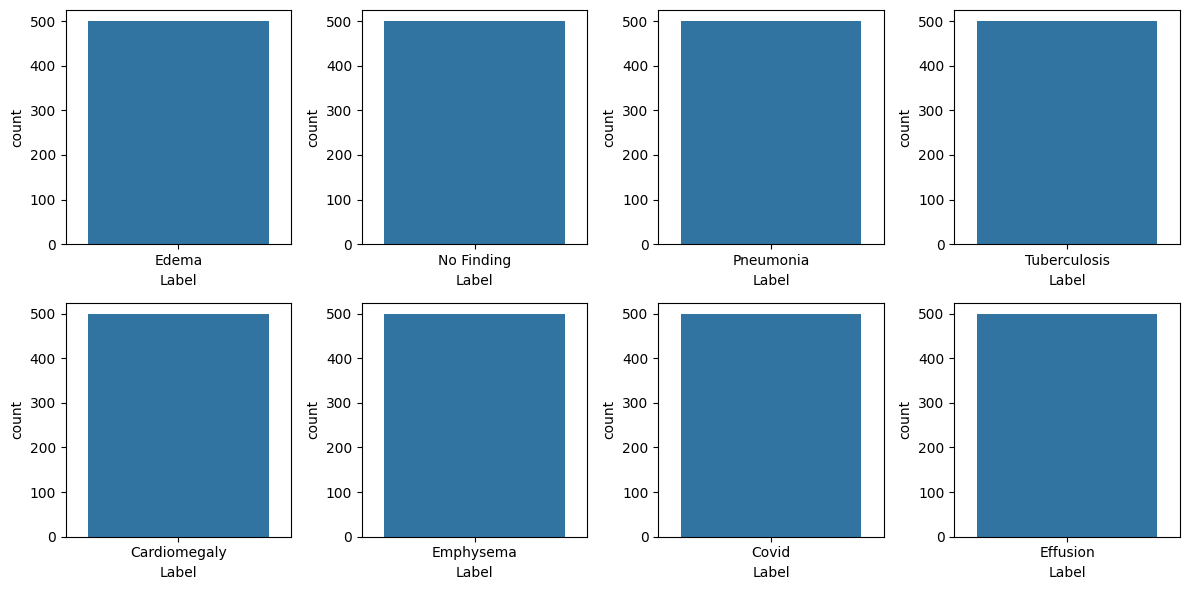

In [14]:
plt.figure(figsize=(12,6))
plt.subplot(2,4,1)
sns.countplot(x=df_1['Label'])
plt.subplot(2,4,2)
sns.countplot(x=df_2['Label'])
plt.subplot(2,4,3)
sns.countplot(x=df_3['Label'])
plt.subplot(2,4,4)
sns.countplot(x=df_4['Label'])
plt.subplot(2,4,5)
sns.countplot(x=df_5['Label'])
plt.subplot(2,4,6)
sns.countplot(x=df_6['Label'])
plt.subplot(2,4,7)
sns.countplot(x=df_7['Label'])
plt.subplot(2,4,8)
sns.countplot(x=df_8['Label'])
plt.tight_layout()
plt.show()

df = df.drop(columns=['Label'])

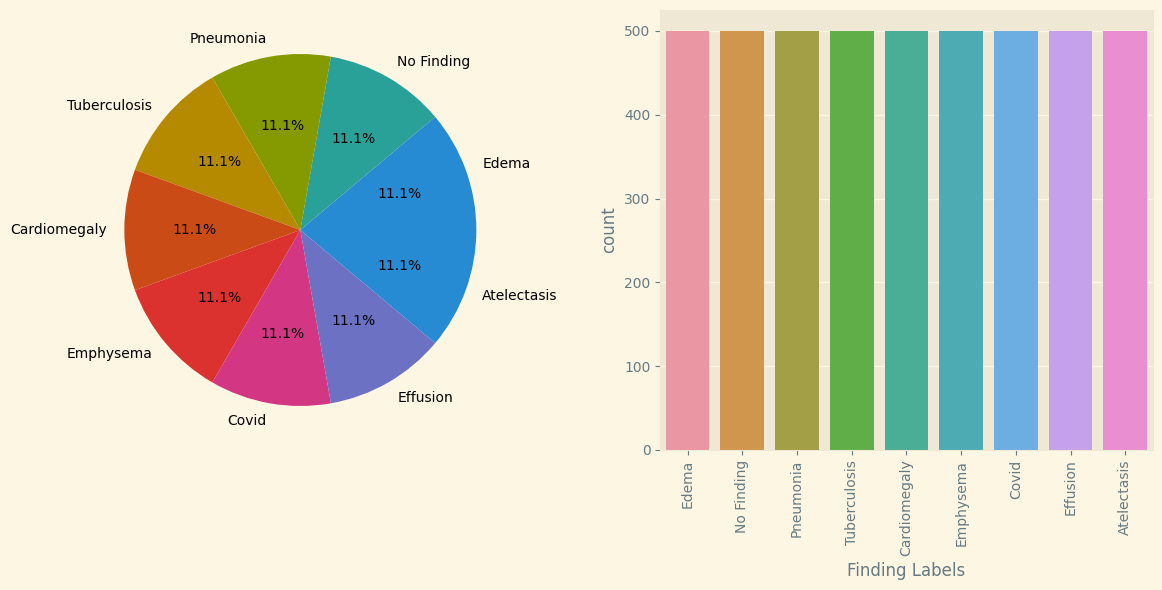

In [15]:
label_counts = df['Finding Labels'].value_counts()

plt.style.use('Solarize_Light2')

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.pie(df['Finding Labels'].value_counts(), labels=label_counts.index, autopct='%.1f%%')
# plt.legend()
plt.subplot(1,2,2)
sns.countplot(x=df['Finding Labels'], order= label_counts.index)
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

**Train & Test Split**

In [16]:
df_train, df_test = train_test_split(df, test_size=0.2, shuffle=True, random_state=42)
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

**One Hot Encoding**

In [17]:
for col in df['Finding Labels'].unique():
    df_test[col] = np.where(df_test['Finding Labels'].str.contains(col), 1.0, 0).astype('float32')
    df_train[col] = np.where(df_train['Finding Labels'].str.contains(col), 1.0, 0).astype('float32')
TARGET = df_train.columns[-9:].tolist()

In [18]:
TARGET

['Edema',
 'No Finding',
 'Pneumonia',
 'Tuberculosis',
 'Cardiomegaly',
 'Emphysema',
 'Covid',
 'Effusion',
 'Atelectasis']

## 3. Build DataGenerator
___

In [19]:
import albumentations as albu
print(albu.__version__)

1.4.0


In [20]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, data, batch_size=16, shuffle=False, augment1=False, augment2=False, preprocess=None):
        super().__init__()
        self.data = data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augment1 = augment1
        self.augment2 = augment2
        self.on_epoch_end()
        self.preprocess = preprocess
        self.clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4,4))
        
    def __len__(self):
        
        # Drop_Last = False
        ct = int(np.ceil(len(self.data)/self.batch_size))
        return ct
    
    def __getitem__(self,index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        X, y = self.__data_generation(indexes)
        if self.preprocess != None: X = self.preprocess(X)
        if self.augment1: X = self.__augment1(X)
        if self.augment2: X = self.__augment2(X)
        return X,y
    
    def on_epoch_end(self,):
        self.indexes = np.arange(len(self.data))
        if self.shuffle: np.random.shuffle(self.indexes)
        
    def __data_generation(self, indexes):
        
        X = np.zeros((len(indexes),256,256,3), dtype='float32') 
        y = np.zeros((len(indexes),len(TARGET)), dtype='float32')
        
        for j,i in enumerate(indexes):
            row = self.data.iloc[i]
            path = row['path']
            img = Image.open(path).convert('L')
            img = img.resize((256,256), Image.Resampling.LANCZOS) # DownSampling
            img = np.array(img) # PIL Object -> np.array(uint8)
            img = self.clahe.apply(img)
            img = np.expand_dims(img, axis=-1)
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB) 
            # img = cv2.bilateralFilter(img, d=5, sigmaColor=75, sigmaSpace=75)
            
            # FillNaN
            m = np.nanmean(img)
            img = np.nan_to_num(img, nan=m)
            
            X[j,:,:] = img
            y[j,] = row[TARGET]
            
        return X,y
    
    def __augment1(self, img_batch):
        
        composition = albu.Compose([
            albu.HorizontalFlip(p=0.5),            
            
        ])
        
        for i in range(img_batch.shape[0]):
            img = composition(image=img_batch[i,])['image']
            img_batch[i,] = img
            
        return img_batch
    
    
    def __augment2(self, img_batch, mixup_prob=0.1):
        batch_size, height, width, channels = img_batch.shape

        idx = np.random.permutation(batch_size)
        lam = np.random.beta(2.0, 2.0) 
        
        for i in range(batch_size):
            if np.random.rand() <= mixup_prob:  
                j = idx[i]
            
                img_batch[i] = img_batch[i] * lam + img_batch[j] * (1-lam)
        
        return img_batch


## 4. Build ResNet Model 
___

**Install ResNet**

In [21]:
!pip install -q git+https://github.com/qubvel/classification_models.git

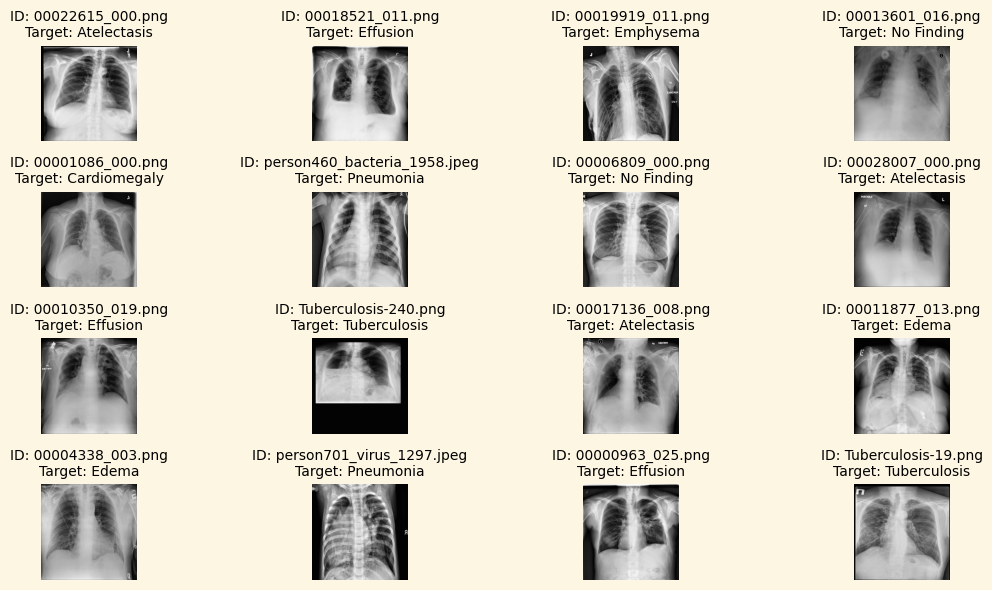

In [22]:
from classification_models.tfkeras import Classifiers

resnet18, preprocess_input = Classifiers.get('resnet18')

ROWS = 4; COLS = 4; BATCHES = 1

gen = DataGenerator(df_train, batch_size=16, shuffle=False, augment1=True, augment2=False, preprocess=None)

for i, (x,y) in enumerate(gen):
    plt.figure(figsize=(12,6))
    for j in range(ROWS):
        for k in range(COLS):
            plt.subplot(ROWS, COLS, j*COLS+k+1)
            img_id = df_train.iloc[i*16+j*COLS+k]['Image Index']
            plt.title(f'ID: {img_id}\nTarget: {df_train.iloc[i*16+j*COLS+k]["Finding Labels"]}', size=10)
            img = x[j*COLS+k,:,:,:3]
            img = img.astype('uint8')
            plt.imshow(img)
            plt.axis('off')
    plt.tight_layout()
    plt.show()
    if i==BATCHES-1: break

#### Macro F1_Score

In [23]:
def f1_score(y_true, y_pred):
    # Calculate the F1 score for each class
    f1_scores = []
    num_classes = K.int_shape(y_pred)[-1]  # (batch_size, output_dims = num_classes)
    
    # Get the true and predicted class indices
    y_true = K.argmax(y_true, axis=-1)
    y_pred = K.argmax(y_pred, axis=-1) # For Label Smoothing(in CCE)

    for i in range(num_classes):
        true_positives = K.sum(K.cast(tf.logical_and(K.equal(y_true, i), K.equal(y_pred, i)), dtype=tf.float32))
        possible_positives = K.sum(K.cast(K.equal(y_true, i), dtype=tf.float32))
        predicted_positives = K.sum(K.cast(K.equal(y_pred, i), dtype=tf.float32))

        recall = true_positives / (possible_positives + K.epsilon())
        precision = true_positives / (predicted_positives + K.epsilon())
        
        f1_score = 2 * ((precision * recall) / (precision + recall + K.epsilon()))
        f1_scores.append(f1_score)
    
    # Calculate the macro-average F1 score
    macro_f1_score = K.mean(tf.stack(f1_scores))
    return macro_f1_score

**ReduceLROnPleateau in Callbacks**

In [24]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

EPOCHS = 10

lr = ReduceLROnPlateau(monitor = 'val_f1_score', factor = 0.1, patience = 1, min_delta = 0.01,
                              mode='max',verbose=1)

In [25]:
def build_model():
    inp = tf.keras.layers.Input(shape=(256,256,3))
    
    res_model = resnet18(include_top=False, weights='imagenet', input_shape=(256,256,3))
    
    ## Freezing Layers
    for layer in res_model.layers[:len(res_model.layers)//10]:
        layer.trainable = False
        
    # Output
    x = res_model(inp)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(len(TARGET), activation='softmax', dtype='float32')(x)
    
    # Compile
    model = tf.keras.Model(inputs=inp, outputs=x)
    
    loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1)
    opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
  
    model.compile(loss=loss, optimizer=opt, metrics=['accuracy', f1_score])
    
    return model

In [26]:
from tensorflow.keras.utils import plot_model

model = build_model()
model.summary()
#plot_model(model, show_shapes=True, show_layer_names=True, expand_nested=True)

44920640/44920640 [==============================] - 1s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 model (Functional)          (None, 8, 8, 512)         11186889  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 9)                 4617      
                                                                 
Total params: 11191506 (42.69 MB)
Trainable params: 11174025

#### StratifiedKFold

In [27]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for i, (_, valid_index) in enumerate(skf.split(df_train, df_train['Finding Labels'])):
    df_train.loc[valid_index, 'Fold'] = i

#########################
### Fold 1
### train size 2880, valid size 720
#########################
Epoch 1/10


I0000 00:00:1722844397.198209      78 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


180/180 [==============================] - 151s 714ms/step - loss: 1.7980 - accuracy: 0.4285 - f1_score: 0.2561 - val_loss: 2.4143 - val_accuracy: 0.4097 - val_f1_score: 0.2999 - lr: 0.0010
Epoch 2/10
180/180 [==============================] - ETA: 0s - loss: 1.5256 - accuracy: 0.5184 - f1_score: 0.3132
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
180/180 [==============================] - 87s 483ms/step - loss: 1.5256 - accuracy: 0.5184 - f1_score: 0.3132 - val_loss: 2.3463 - val_accuracy: 0.3458 - val_f1_score: 0.2078 - lr: 0.0010
Epoch 3/10
180/180 [==============================] - 87s 484ms/step - loss: 1.2741 - accuracy: 0.6483 - f1_score: 0.4023 - val_loss: 1.2474 - val_accuracy: 0.6625 - val_f1_score: 0.5255 - lr: 1.0000e-04
Epoch 4/10
180/180 [==============================] - 88s 488ms/step - loss: 1.1903 - accuracy: 0.6951 - f1_score: 0.4338 - val_loss: 1.2384 - val_accuracy: 0.6847 - val_f1_score: 0.5519 - lr: 1.0000e-04
Epoch 5/10
180/180 [=

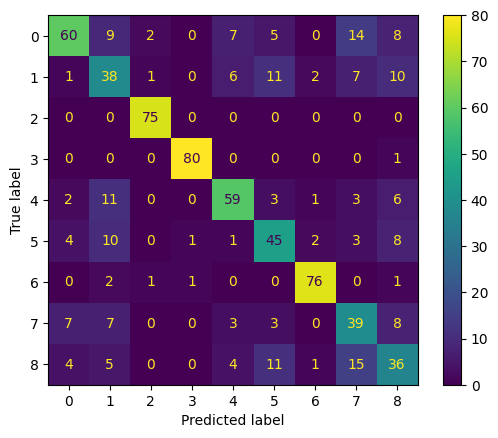

In [28]:
import tensorflow.keras.backend as K

all_oof = []
all_true = []
all_history = defaultdict(list)

for i in range(1):
    
    print('#'*25)
    print(f'### Fold {i+1}')
    
    train_gen = DataGenerator(df_train[df_train['Fold'] != i], shuffle=True, augment1=True, augment2=False, batch_size=16, preprocess=preprocess_input)
    valid_gen = DataGenerator(df_train[df_train['Fold'] == i], shuffle=False, batch_size=32, preprocess=preprocess_input)
    
    print(f'### train size {len(df_train[df_train["Fold"] != i])}, valid size {len(df_train[df_train["Fold"] == i])}')
    print('#'*25)
    
    K.clear_session()
    with strategy.scope():
        model = build_model()
    if LOAD_MODELS_FROM is None:
        history =  model.fit(train_gen, verbose=1,
              validation_data = valid_gen,
              epochs=EPOCHS, callbacks = [lr])
        model.save_weights(f'ResNet_f{i}.weights.h5')
        all_history['Train Loss'].append(history.history['loss'])
        all_history['Valid Loss'].append(history.history['val_loss'])
        all_history['Valid F1'].append(history.history['val_f1_score'])
        all_history['Train F1'].append(history.history['f1_score'])
        all_history['Valid Accuracy'].append(history.history['val_accuracy'])
        all_history['Train Accuracy'].append(history.history['accuracy'])

    else:
        model.load_weights(f'{LOAD_MODELS_FROM}ResNet_f{i}.weights.h5')
        
    oof = model.predict(valid_gen, verbose=1)
    all_oof.append(oof)
    all_true.append(df_train[df_train['Fold'] == i][TARGET].values)
    
    plt.style.use('default')
    cm = confusion_matrix(np.argmax(oof, axis=1), np.argmax(df_train[df_train['Fold'] == i][TARGET].values, axis=1), labels=[x for x in range(len(TARGET))])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[x for x in range(len(TARGET))])  
    disp.plot()
    plt.show()
    
    del model, oof, train_gen, valid_gen
    gc.collect()
    
all_oof = np.concatenate(all_oof)
all_true = np.concatenate(all_true)

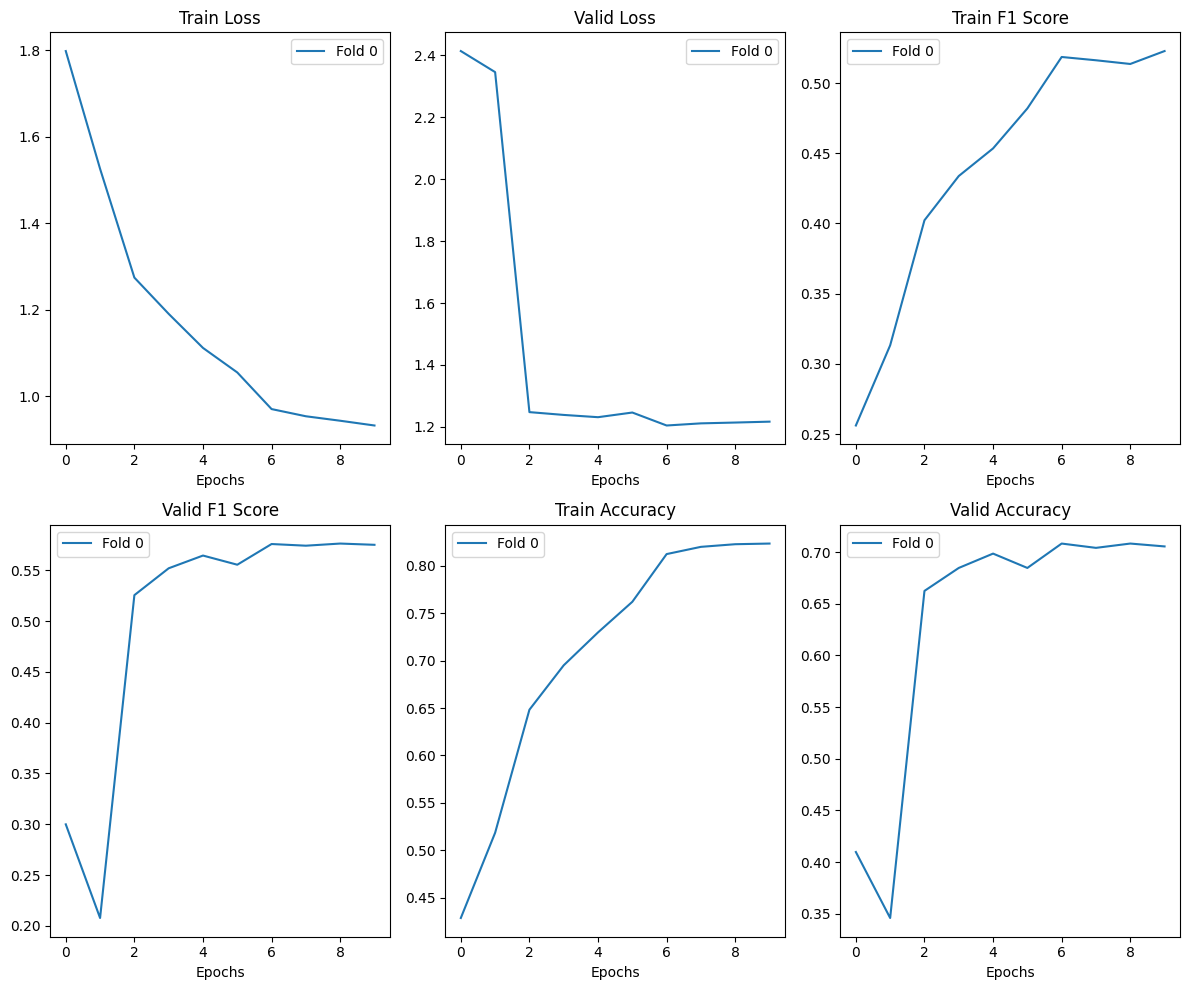

In [29]:
if LOAD_MODELS_FROM is None:
    plt.figure(figsize=(12,10))
    plt.subplot(2,3,1)
    plt.title('Train Loss')
    for fold, i in enumerate(all_history['Train Loss']):
        plt.plot(i, label=f'Fold {fold}')
        plt.xlabel('Epochs')
    plt.legend()

    plt.subplot(2,3,2)
    plt.title('Valid Loss')
    for fold, i in enumerate(all_history['Valid Loss']):
        plt.plot(i,label=f'Fold {fold}')
        plt.xlabel('Epochs')
    plt.legend()

    plt.subplot(2,3,3)
    plt.title('Train F1 Score')
    for fold, i in enumerate(all_history['Train F1']):
        plt.plot(i, label=f'Fold {fold}')
        plt.xlabel('Epochs')
    plt.legend()
    
    plt.subplot(2,3,4)
    plt.title('Valid F1 Score')
    for fold, i in enumerate(all_history['Valid F1']):
        plt.plot(i, label=f'Fold {fold}')
        plt.xlabel('Epochs')
    plt.legend()

    plt.subplot(2,3,5)
    plt.title('Train Accuracy')
    for fold, i in enumerate(all_history['Train Accuracy']):
        plt.plot(i, label=f'Fold {fold}')
        plt.xlabel('Epochs')
    plt.legend()

    plt.subplot(2,3,6)
    plt.title('Valid Accuracy')
    for fold, i in enumerate(all_history['Valid Accuracy']):
        plt.plot(i, label=f'Fold {fold}')
        plt.xlabel('Epochs')
    plt.legend()


    
    plt.tight_layout()
    plt.show()

In [30]:
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc

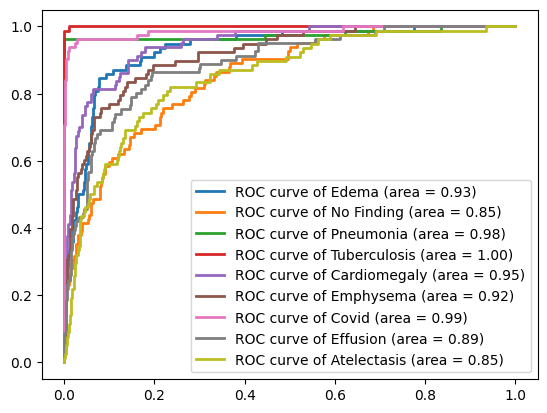

In [31]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(TARGET)):
    fpr[i], tpr[i], _ = roc_curve(all_true[:, i], all_oof[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# ROC 곡선 그리기
plt.figure()
for i in range(len(TARGET)):
    plt.plot(fpr[i], tpr[i], lw=2,
             label=f'ROC curve of {TARGET[i]} (area = {roc_auc[i]:0.2f})')
plt.legend()
plt.show()

In [32]:
# Accuracy
accuracy = accuracy_score(np.argmax(all_true, axis=1), np.argmax(all_oof, axis=1))
print('Accuracy for Train Set =', accuracy)

# F1 Score
f1 = f1_score(np.argmax(all_true, axis=1), np.argmax(all_oof, axis=1) , average='macro')
print('F1 Score for Train Set =', f1)

Accuracy for Train Set = 0.7055555555555556
F1 Score for Train Set = 0.7029670043876235


#### Inference

Fold 1
15/15 [==============================] - 31s 2s/step
Accuracy for Test Set = 0.6611111111111111
F1 Score for Test Set = 0.6681806987521295


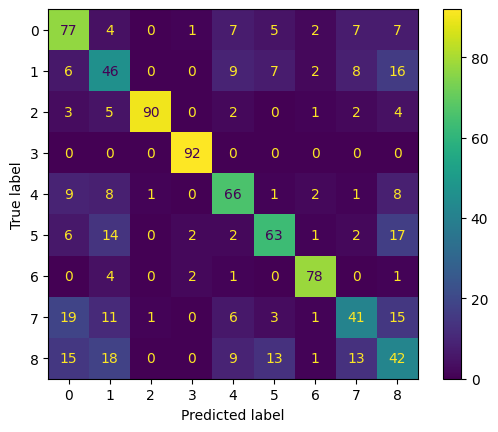

In [33]:
preds = []
model = build_model()

## No TTA
test_gen = DataGenerator(df_test, shuffle=False, batch_size=64, preprocess=preprocess_input)

for i in range(1):
    print(f'Fold {i+1}') 
    if LOAD_MODELS_FROM:
        model.load_weights(f'{LOAD_MODELS_FROM}ResNet_f{i}.weights.h5')
    else: 
        model.load_weights(f'ResNet_f{i}.weights.h5')
    
    pred = model.predict(test_gen, verbose=1) 
    
preds.append(pred)
pred_res = np.mean(preds,axis=0)
    
# Accuracy 
accuracy = accuracy_score(np.argmax(df_test[TARGET].values, axis=1), np.argmax(pred_res, axis=1))
print('Accuracy for Test Set =', accuracy)

# F1 Score 
f1 = f1_score(np.argmax(df_test[TARGET].values, axis=1), np.argmax(pred_res, axis=1), average='macro') 
print('F1 Score for Test Set =', f1)

cm = confusion_matrix(np.argmax(df_test[TARGET].values, axis=1), np.argmax(pred_res, axis=1), labels=[x for x in range(len(TARGET))])
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[x for x in range(len(TARGET))])
display.plot()
plt.show()

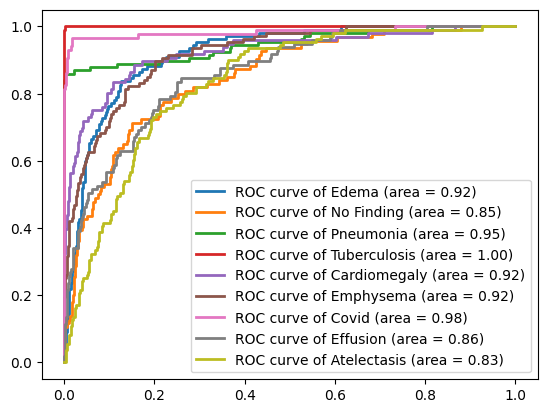

In [34]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(TARGET)):
    fpr[i], tpr[i], _ = roc_curve(df_test[TARGET[i]], pred_res[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# ROC 곡선 그리기
plt.figure()
for i in range(len(TARGET)):
    plt.plot(fpr[i], tpr[i], lw=2,
             label=f'ROC curve of {TARGET[i]} (area = {roc_auc[i]:0.2f})')
plt.legend()
plt.show()